📅 CSV'deki son veri: 2025-04-30 12:00:01.006000+00:00
⬇️ Çekiliyor: 2025-04-30T12:00:01.000Z - 2025-04-30T12:20:59.000Z
📦 3 veri alındı.
✅ Güncellendi: 3_years_hourly_temperature.csv (22836 kayıt)


14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] done processing
14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:01 - cmdstanpy - INFO - Chain [1] done processing



📊 Test Seti Doğruluk Metrikleri:
Minimum Sıcaklık -> MAE: 3.62, R²: 0.02
Maksimum Sıcaklık -> MAE: 3.00, R²: 0.07



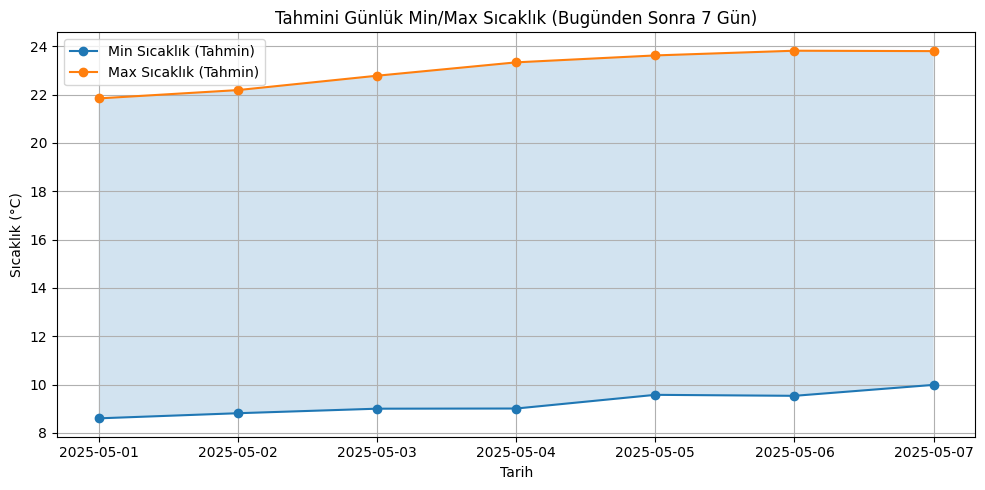

In [30]:
from update_temperature_data import fetch_temperature_auto
from datetime import datetime, timezone
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# 🔹 1. Veriyi çek ve temizle
df = fetch_temperature_auto(
    senseBoxId="60a048f7a877b3001b1f9995",
    sensorId="60a048f7a877b3001b1f9996",
    csv_path="3_years_hourly_temperature.csv",
    fallback_start=datetime(2022, 1, 1, tzinfo=timezone.utc)
)

df['value'] = pd.to_numeric(df['value'], errors='coerce')
df.dropna(subset=['value'], inplace=True)

# 🔹 2. Günlük min/max sıcaklıkları hesapla
df['date'] = df['createdAt'].dt.date
daily_min = df.groupby('date')['value'].min().reset_index()
daily_max = df.groupby('date')['value'].max().reset_index()

# Prophet formatına çevir
daily_min.columns = ['ds', 'y']
daily_max.columns = ['ds', 'y']
daily_min['ds'] = pd.to_datetime(daily_min['ds'])
daily_max['ds'] = pd.to_datetime(daily_max['ds'])

# 🔹 3. Train/Test ayrımı (son 30 gün test)
split_date = daily_min['ds'].max() - pd.Timedelta(days=30)
train_min = daily_min[daily_min['ds'] <= split_date]
test_min = daily_min[daily_min['ds'] > split_date]

train_max = daily_max[daily_max['ds'] <= split_date]
test_max = daily_max[daily_max['ds'] > split_date]

# 🔹 4. Prophet modellerini eğit
model_min = Prophet()
model_max = Prophet()
model_min.fit(train_min)
model_max.fit(train_max)

# 🔹 5. Test verisi tahmini ve metrikler
future_test_min = pd.DataFrame({'ds': test_min['ds']})
future_test_max = pd.DataFrame({'ds': test_max['ds']})

forecast_min_test = model_min.predict(future_test_min)
forecast_max_test = model_max.predict(future_test_max)

# 🔹 6. Doğruluk metriklerini yazdır
mae_min = mean_absolute_error(test_min['y'], forecast_min_test['yhat'])
r2_min = r2_score(test_min['y'], forecast_min_test['yhat'])

mae_max = mean_absolute_error(test_max['y'], forecast_max_test['yhat'])
r2_max = r2_score(test_max['y'], forecast_max_test['yhat'])

print(f"\n📊 Test Seti Doğruluk Metrikleri:")
print(f"Minimum Sıcaklık -> MAE: {mae_min:.2f}, R²: {r2_min:.2f}")
print(f"Maksimum Sıcaklık -> MAE: {mae_max:.2f}, R²: {r2_max:.2f}\n")

# 🔹 7. Gelecek 7 gün için tahmin (bugünden itibaren)
from datetime import timedelta

today = datetime.now(timezone.utc).date()
future_dates = pd.date_range(start=today + pd.Timedelta(days=1), periods=7, freq='D')

future_df_min = pd.DataFrame({'ds': future_dates})
future_df_max = pd.DataFrame({'ds': future_dates})

forecast_min_7 = model_min.predict(future_df_min)
forecast_max_7 = model_max.predict(future_df_max)

# 🔹 8. Tahminleri görselleştir
plt.figure(figsize=(10, 5))
plt.plot(forecast_min_7['ds'], forecast_min_7['yhat'], label='Min Sıcaklık (Tahmin)', marker='o')
plt.plot(forecast_max_7['ds'], forecast_max_7['yhat'], label='Max Sıcaklık (Tahmin)', marker='o')
plt.fill_between(forecast_min_7['ds'], forecast_min_7['yhat'], forecast_max_7['yhat'], alpha=0.2)
plt.title("Tahmini Günlük Min/Max Sıcaklık (Bugünden Sonra 7 Gün)")
plt.xlabel("Tarih")
plt.ylabel("Sıcaklık (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
